In [4]:
import agent_code.vkl.models as models
from agent_code.vkl.data import MoveDataset
from torch.utils.data import DataLoader
from torch import load, save
import pytorch_lightning as L
import torch
from os import listdir
from os.path import join
import matplotlib.pyplot as plt
from gc import collect

# Parameters

In [5]:
radius = 16
epochs = 1000
batch_size = 512
torch.set_float32_matmul_precision("medium")
dtype = torch.float32
precision = "16-mixed"

# Data

In [6]:
# join 4 datasets
dir = "agent_code/watcher/output/"
filenames = [f for f in listdir(dir) if f[-3:] == ".pt"][:1]
paths = [join(dir, f) for f in filenames]
packed = sum([load(path, weights_only=False) for path in paths], [])

dataset = MoveDataset(packed, radius=radius, dtype=dtype)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=32,
    pin_memory=True,
    persistent_workers=True,
)
del packed
collect()

0

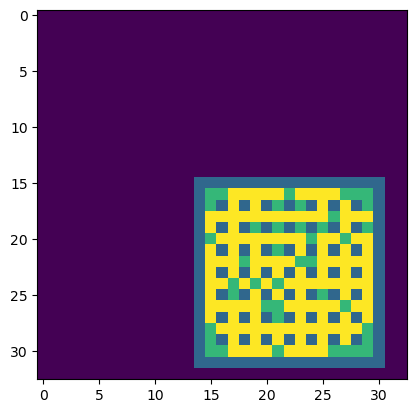

In [7]:
plt.imshow(dataset[2][0][0, ...])

# Model definition

In [4]:
raw_model = models.BasicModel(radius)
raw_model.to(dtype)
total_steps = epochs * len(dataloader)
model = models.LitBasicModel(raw_model, total_steps=total_steps)
# model = torch.compile(model) # doesn't work for now

final conv layer side: 4


# Training

In [ ]:
trainer = L.Trainer(accelerator="gpu", max_epochs=epochs, precision=precision)
trainer.fit(model=model, train_dataloaders=dataloader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | BasicModel | 1.1 M  | train
---------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.380     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Training: |                                                                                                   …

# Save the model

In [ ]:
save((raw_model, radius), "agent_code/vkl/output/model.pt")